In [36]:
import numpy as np
import pickle
import Tkinter as tk
%matplotlib inline
import cv2

In [64]:
with open('recording.pkl') as f:
    source = pickle.load(f)

In [53]:
def get_perspective_transform(inverse=False):        
    p1 = (232, 380) # top left
    p2 = (360, 380) # top right
    p3 = (206, 414) # bottom left
    p4 = (383, 414) # bottom right

    pts1 = np.float32([list(p1),list(p2),list(p3),list(p4)])
    output_width = 100
    output_height = 35
    dx=250
    dy=585
    pts2 = np.float32([[dx,dy],[dx+output_width,dy],[dx,dy+output_height],[dx+output_width,dy+output_height]])
    if inverse:
        M = cv2.getPerspectiveTransform(pts2,pts1)
    else:
        M = cv2.getPerspectiveTransform(pts1,pts2)
    return M

def transform_anchor_points(points, M):
    points = np.array(points, dtype=np.float32)
    transformed = cv2.perspectiveTransform(points[None, :, :], M)
    return transformed.tolist()[0]

def compute_topdown_image(image_filename, transformation_matrix, transformation_size):
    img = cv2.imread(image_filename)
    img = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)
    dst = cv2.warpPerspective(img, transformation_matrix, (transformation_size , transformation_size))
    dst = cv2.cvtColor(dst, cv2.cv.CV_BGR2RGB)
    dst_img = Image.fromarray(dst)
    return dst_img

In [112]:


def calculate_affordances(frame_data, image_center, front=False, perspective_transform=None):
    splines = []
    
    for lane_data in frame_data.values():
        anchor_points = lane_data['anchor_points']
        if front and perspective_transform is not None:
            anchor_points = transform_anchor_points(anchor_points, perspective_transform)
        splines.append(anchor_points)

    # splines sorted by blue X value
    splines = sorted(splines, key=lambda spline: spline[2][0])

    # comput distance from lane x to center of the image
    spline_to_center_distances = []
    for index in range(len(splines)):
        spline = splines[index]
        distance = image_center - spline[2][0]
        spline_to_center_distances.append([index, distance])

    # sort by distance.  If distance is negative (right lane) it is put at the bottom
    closest_left_splines = sorted(spline_to_center_distances, key=lambda x: x[1] if x[1] >=0 else 999999999)
    left_lane1_index = closest_left_splines[0][0]
    left_lane2_index = left_lane1_index - 1
    right_lane1_index = left_lane1_index + 1
    right_lane2_index = right_lane1_index + 1

    displacement_indicies = [left_lane2_index, left_lane1_index, right_lane1_index, right_lane2_index]
    displacements = []
    for displacement_index in displacement_indicies:
        displacements.append(spline_to_center_distances[displacement_index][1])
    
    left_spline = splines[left_lane1_index]
    right_spline = splines[right_lane1_index]
    
    
    middle_anchor_average = ((np.array(left_spline[1]) + np.array(right_spline[1]))/2.0)
    bottom_anchor_average = ((np.array(left_spline[2]) + np.array(right_spline[2]))/2.0)
    
    anchor_diff = bottom_anchor_average - middle_anchor_average
#     print middle_anchor_average
#     print bottom_anchor_average
#     print anchor_diff
    slope = -anchor_diff[0]/(anchor_diff[1])
    angle = np.arctan(slope)
    displacements.append(slope)
    return displacements

In [71]:
frame_data =source['lanes']['images/frame0102.jpg']

In [87]:
np.array([2,3.])/np.array([4.,7])

array([ 0.5       ,  0.42857143])

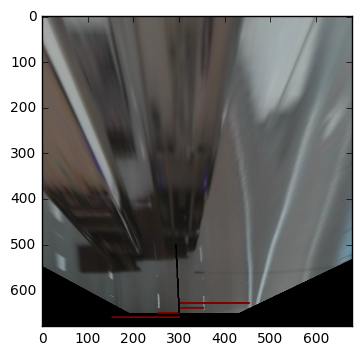

In [119]:
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import cv2

def display_affordances(source, image_file):
    frame_data =source['lanes'][image_file]
    im = compute_topdown_image(image_file, source['front_to_topdown_transformation'], source['transformation_size']) 
    draw = ImageDraw.Draw(im) 
    center_x = 300
    affordences=calculate_affordances(frame_data, center_x)
    for i in range(len(affordences)):
        y = 670 -((i+1)*10)
        x = center_x-affordences[i]
        draw.line([x, y, center_x, y], fill=128, width=4)

    heading_dx = np.tan(affordences[4])*150
    draw.line([center_x, 650, center_x + heading_dx, 500], fill=256, width=4)
    imshow(im)

    
display_affordances(source, 'images/frame0599.jpg')

In [100]:
affordences

[158, 57, -42, -137, 0.058823529411764705]

In [104]:
np.tan(affordences[4])*100

5.8891470657728382

In [57]:
source['front_to_topdown_transformation'] = source['topdown_to_front_transformation']

In [58]:
source['topdown_to_front_transformation'] =a

In [59]:
source['topdown_to_front_transformation']

array([[  2.27469880e-01,  -4.21572002e-01,   2.30981067e+02],
       [ -2.75335310e-14,  -4.09294320e-01,   3.06967298e+02],
       [ -6.98226199e-17,  -1.40562249e-03,   1.00000000e+00]])

In [60]:
source['front_to_topdown_transformation']

array([[ -2.38295486e-01,  -1.04079058e+00,   3.74530418e+02],
       [ -1.70974346e-14,  -2.44322960e+00,   7.49991590e+02],
       [ -3.12250226e-17,  -3.43425848e-03,   1.00000000e+00]])

In [ ]:
with op